In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob 
import glob as gb
from PIL import Image
import tensorflow as tf
import imageio
import os
from tensorflow.keras import layers
import time
import pandas as pd
from IPython import display
import cv2

In [2]:
trainpath ='/kaggle/input/anime-faces/'
image_size=64
X_train = []

for folder in os.listdir(trainpath):
    files = gb.glob(pathname= str( trainpath +folder+ '/*.png'))
    print( 'numbers of images in folder are : ', len(files))
    print(' start reading images')
    for file in files: 
        orignal_image = cv2.imread(file)
        image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2GRAY)
        image = image / 255.0
        resized_image = cv2.resize(image , (image_size,image_size))
        X_train.append(resized_image)
    print('image reading ...finished')
    print('--------------------------------------------------')        

    print("items in X_train is:       ",len(X_train) , " items") 

numbers of images in folder are :  21551
 start reading images
image reading ...finished
--------------------------------------------------
items in X_train is:        21551  items


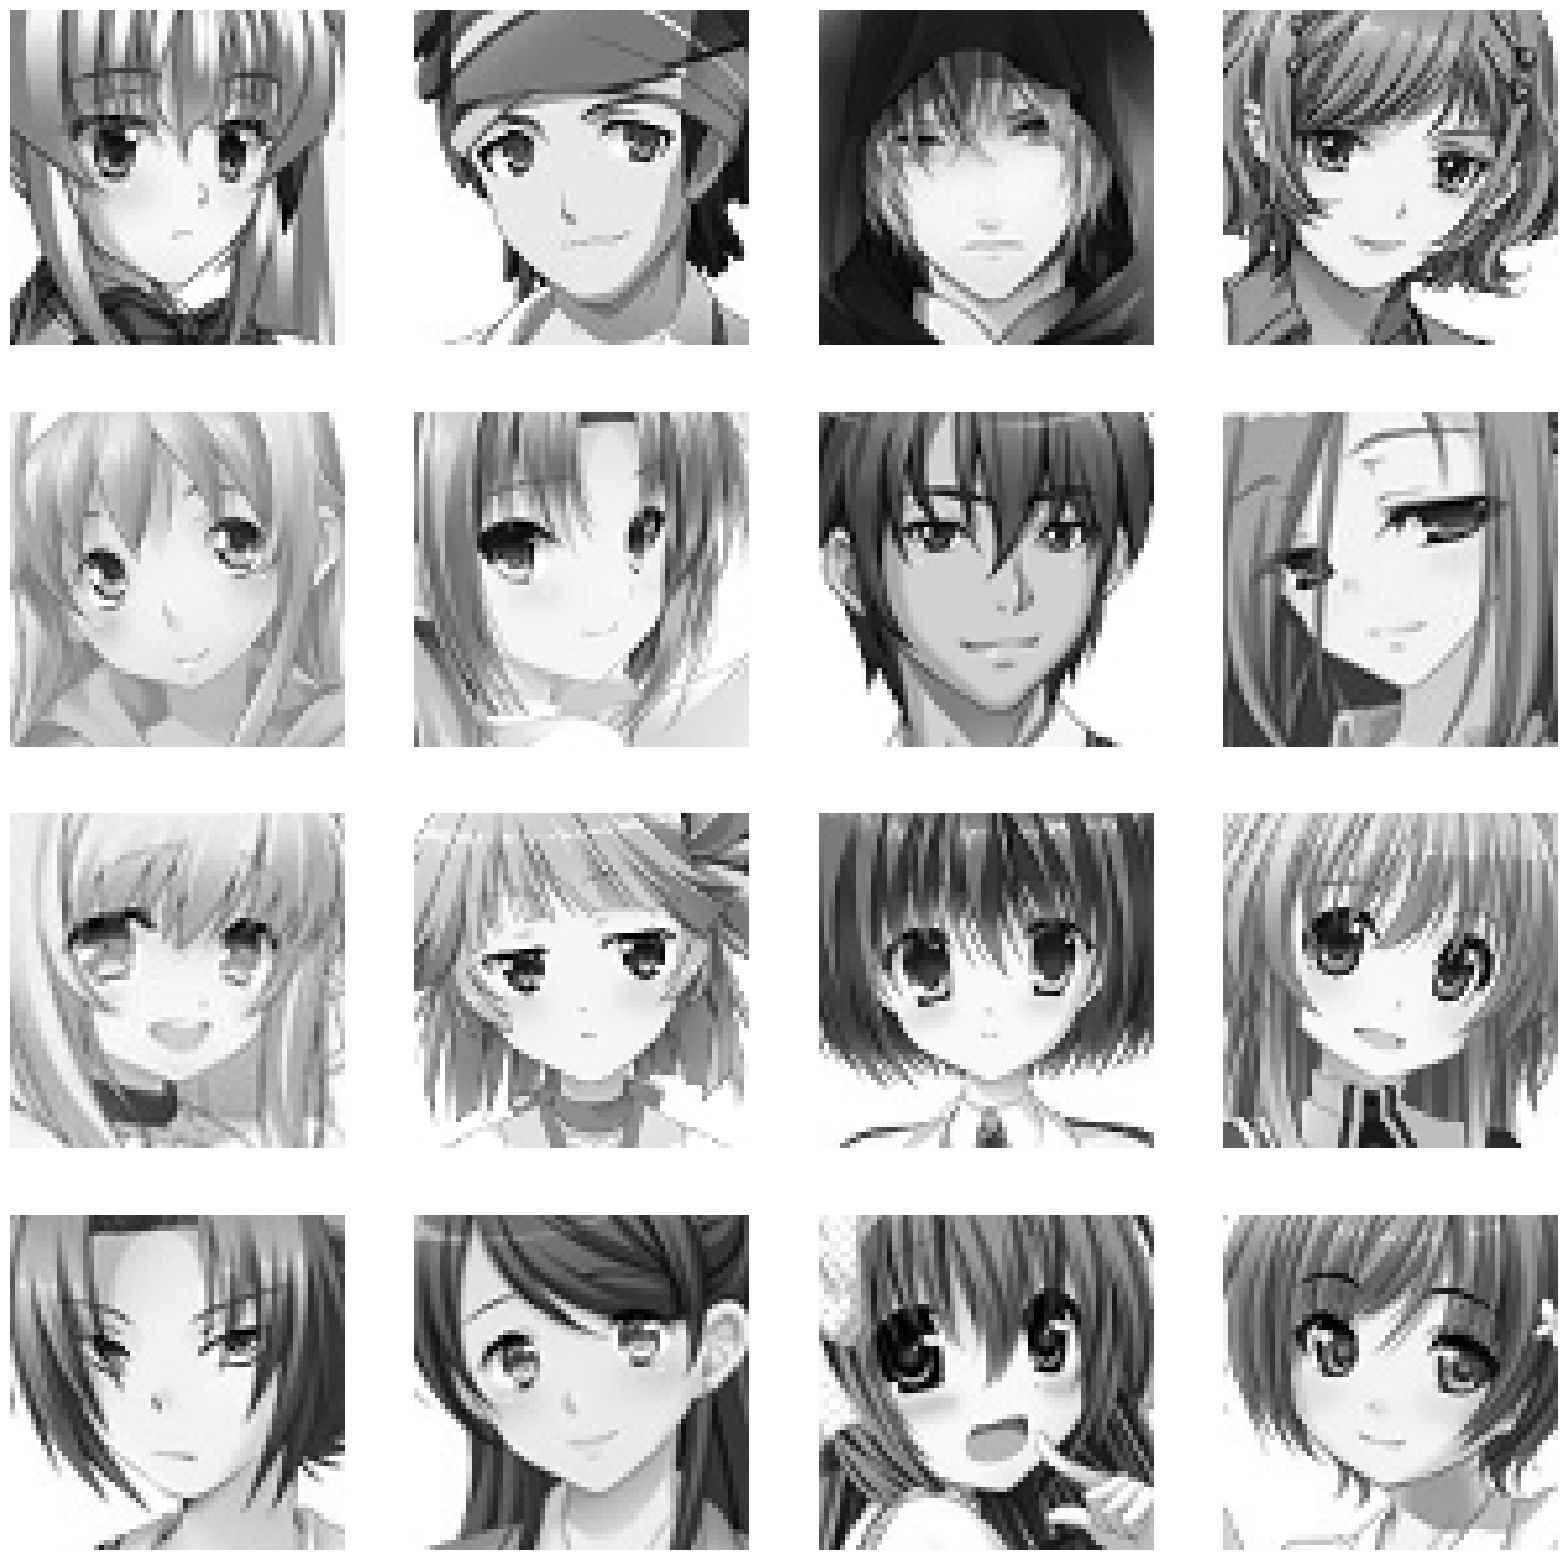

In [3]:
#showing training images with labels
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train ),16))) : 
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')   
    plt.axis('off')

In [5]:
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1).astype('float32')

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_size, image_size, 4)))
    assert model.output_shape == (None, image_size, image_size, 4)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, image_size, image_size, 1)

    return model

In [10]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 64, 64, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 64)          │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 1)           │             800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,762,720 (6.72 MB)

 Trainable params: 1,729,760 (6.60 MB)

 Non-trainable params: 32,960 (128.75 KB)

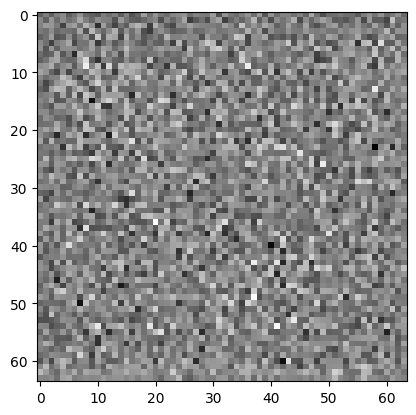

In [11]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray') #

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[image_size,image_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dense(1,activation = 'sigmoid'))

    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 468,993 (1.79 MB)

 Trainable params: 468,993 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.52360207]], shape=(1, 1), dtype=float32)


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 500
noise_dim = 100
BATCH_SIZE = 128

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,BATCH_SIZE):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss , disc_loss

In [22]:
def train(dataset, epochs,BATCH_SIZE):
    loss_gen = []
    loss_disc = []
    for epoch in tqdm(range(epochs)):
        L1,L2 =0,0
        start = time.time()

        for image_batch in dataset:
            Ln1 , Ln2 = train_step(image_batch,BATCH_SIZE)
            L1 = L1  +Ln1
            L2 = L2  +Ln2
        # Produce images for the GIF as you go
        loss_gen.append(L1)
        loss_disc.append(L2)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    return loss_gen,loss_disc

In [23]:
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 255.0, cmap='gray') #
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

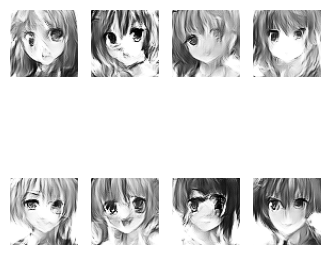

In [24]:
History_gen,History_disc = train(dataset=train_dataset, epochs = EPOCHS,BATCH_SIZE=BATCH_SIZE)


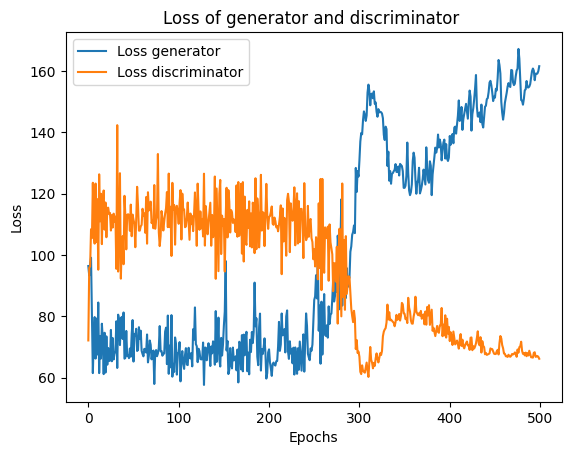

In [25]:
import matplotlib.pyplot as plt
import numpy as np


# Create the plot
plt.plot(range(len(History_gen)), History_gen, label='Loss generator')
plt.plot(range(len(History_disc)), History_disc, label='Loss discriminator')

plt.title('Loss of generator and discriminator ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [27]:
from IPython.display import display

def display_image(epoch_no):
    img = Image.open('/kaggle/working/image_at_epoch_{:04d}.png'.format(epoch_no))
    display(img)


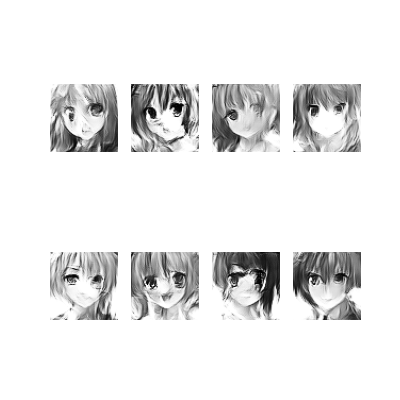

In [28]:
display_image(EPOCHS)
